In [27]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

In [9]:
years = 15

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(362*years)

tickers = ['SPY', 'GLD' , 'BND', 'QQQ', 'VIT']

In [10]:
adj_close = pd.DataFrame()
for tk in tickers:
    data = yf.download(tk,start = start_date ,end = end_date)
    adj_close[tk] = data['Adj Close']

print(adj_close)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY         GLD        BND         QQQ    VIT
Date                                                            
2009-08-31   77.488106   93.400002  51.565468   34.978077  13.67
2009-09-01   75.778954   93.900002  51.625076   34.322712  13.25
2009-09-02   75.491570   96.190002  51.736450   34.296509  12.93
2009-09-03   76.119286   97.459999  51.644672   34.523701  13.06
2009-09-04   77.185616   97.529999  51.592316   35.266434  13.07
...                ...         ...        ...         ...    ...
2024-07-05  554.640015  220.929993  72.400002  496.160004    NaN
2024-07-08  555.280029  218.190002  72.400002  497.339996    NaN
2024-07-09  555.820007  218.559998  72.370003  497.769989    NaN
2024-07-10  561.320007  219.360001  72.430000  502.959991    NaN
2024-07-11  556.479980  223.250000  72.790001  491.929993    NaN

[3740 rows x 5 columns]


In [13]:
log_returns = np.log(adj_close/adj_close.shift(1))
log_returns.dropna(inplace = True)
print(log_returns)

                 SPY       GLD       BND       QQQ       VIT
Date                                                        
2009-09-01 -0.022304  0.005339  0.001155 -0.018914 -0.031206
2009-09-02 -0.003800  0.024095  0.002155 -0.000764 -0.024447
2009-09-03  0.008281  0.013117 -0.001776  0.006603  0.010004
2009-09-04  0.013911  0.000718 -0.001014  0.021286  0.000765
2009-09-08  0.008585 -0.001026 -0.000509  0.009371  0.122955
...              ...       ...       ...       ...       ...
2018-01-18 -0.001682 -0.002222 -0.001977  0.000181 -0.012048
2018-01-19  0.004539  0.004439 -0.002105  0.003131 -0.006079
2018-01-22  0.008098  0.001818 -0.000744  0.010644 -0.018462
2018-01-23  0.002120  0.004962  0.002603  0.008234  0.042560
2018-01-31  0.000496  0.006681  0.000248  0.004141  0.000000

[1586 rows x 5 columns]


## Historical Method

In [40]:
portfolio_value = 100000

weights = np.array([1/len(tickers)]*len(tickers))  ## [0.2]*5
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [41]:
historical_returns = (log_returns * weights).sum(axis =1)
print(historical_returns)

Date
2009-09-01   -0.013186
2009-09-02   -0.000552
2009-09-03    0.007246
2009-09-04    0.007133
2009-09-08    0.027876
                ...   
2018-01-18   -0.003550
2018-01-19    0.000785
2018-01-22    0.000271
2018-01-23    0.012096
2018-01-31    0.002313
Length: 1586, dtype: float64


In [48]:
days = 50

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()
print(range_returns)

Date
2009-11-10    0.113513
2009-11-11    0.132065
2009-11-12    0.121314
2009-11-13    0.138620
2009-11-16    0.146522
                ...   
2018-01-18    0.027646
2018-01-19    0.029534
2018-01-22    0.026868
2018-01-23    0.037257
2018-01-31    0.042516
Length: 1537, dtype: float64


In [49]:
confidence_interval = [0.90,0.95,0.99]
Vars=[]
for cl in confidence_interval:
    Var = (-np.percentile(range_returns, 100 - (cl * 100))*portfolio_value)
    Vars.append(Var)
print(Var)

14291.415387677504


In [50]:
confidence_interval = 0.90
Var = (-np.percentile(range_returns, 100 - (cl * 100))*portfolio_value)
print(Var)

14291.415387677504


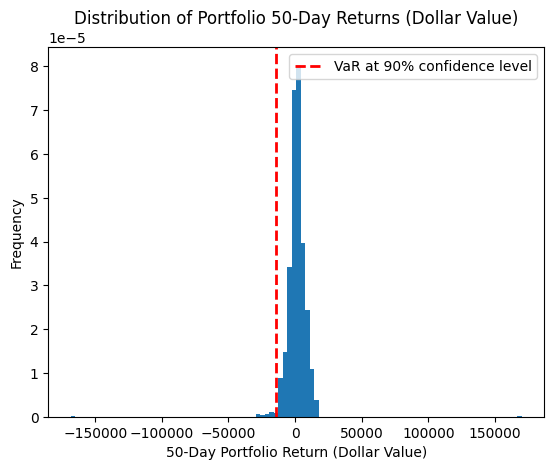

In [52]:
range_returns_dollar = range_returns * portfolio_value

plt.hist(range_returns_dollar.dropna(), bins=100, density=True)
plt.xlabel(f'{days}-Day Portfolio Return (Dollar Value)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns (Dollar Value)')
plt.axvline(-Var, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

## Parametric Approach

In [53]:
portfolio_value = 100000

weights = np.array([1/len(tickers)]*len(tickers))  ## [0.2]*5
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [63]:
days = 50
historical_x_day_returns = historical_returns.rolling(window=days).sum()

In [64]:
cov_matrix = log_returns.cov() * 252
portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

In [65]:
from scipy.stats import norm

confidence_levels = [0.90, 0.95, 0.99]

VaRs = []
for cl in confidence_levels:
    VaR = portfolio_value * (norm.ppf(1 - cl) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

In [66]:
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100:>6.0f}%: {"":<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $-56,907.36
    95%:          $-72,608.32
    99%:          $-102,060.73


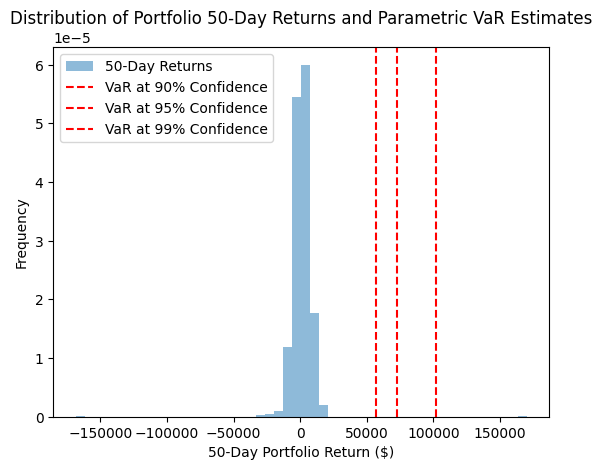

In [67]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=50, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add vertical lines representing VaR at each confidence level
for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x=-VaR, linestyle='--', color='r', label='VaR at {}% Confidence'.format(int(cl * 100)))

plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates')
plt.legend()
plt.show()

## Monte Carlo Simulation

In [69]:
### Create a function that will be used to calculate portfolio expected return

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [70]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

          SPY           GLD       BND           QQQ       VIT
SPY  0.000098  2.155720e-06 -0.000008  1.015515e-04  0.000110
GLD  0.000002  1.022532e-04  0.000005  8.839156e-07  0.000136
BND -0.000008  5.422592e-06  0.000005 -7.649599e-06  0.000026
QQQ  0.000102  8.839156e-07 -0.000008  1.223598e-04  0.000133
VIT  0.000110  1.364344e-04  0.000026  1.326585e-04  0.092061


In [79]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 100000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [80]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 50

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [81]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [82]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

98620.69024041116


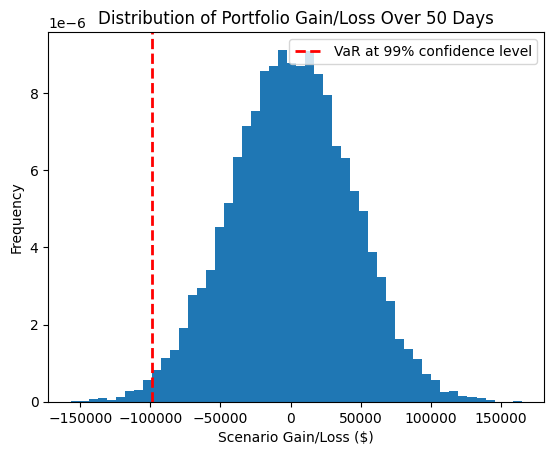

In [83]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()